# Unsupervised Learning -- FIFA 19 Player Data

This capstone analyzes player attributes from a dataset consisting of the players in the FIFA 19 video game.  The subset of players under study are the players who play a position that is classified as a "back" (i.e., the positional abbreviation ends in "B").  The goal of this capstone is to observe whether clustering methods can be used to cluster these "backs" into two groups--center backs and wide backs--based on the attributes assigned to them within the video game.  Doing so will provide information related to the attributes that separate the two groups and are important for each position.  The dataset was obtained from Kaggle.

## Perform imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture as GMM
from itertools import combinations

# Load data

In [2]:
df = pd.read_csv('C:\\Users\\hsvjc\\Desktop\\Thinkful\\FIFA 19 Player Data\\FIFA 19 Player Data.csv')

In [3]:
pd.options.display.max_columns = df.shape[1]
df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Body Type,Real Face,Position,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,https://cdn.sofifa.org/teams/2/light/241.png,€110.5M,€565K,2202,Left,5.0,4.0,4.0,Medium/ Medium,Messi,Yes,RF,10.0,"Jul 1, 2004",NaN,2021,5'7,159lbs,88+2,88+2,88+2,92+2,93+2,93+2,93+2,92+2,93+2,93+2,93+2,91+2,84+2,84+2,84+2,91+2,64+2,61+2,61+2,61+2,64+2,59+2,47+2,47+2,47+2,59+2,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,https://cdn.sofifa.org/teams/2/light/45.png,€77M,€405K,2228,Right,5.0,4.0,5.0,High/ Low,C. Ronaldo,Yes,ST,7.0,"Jul 10, 2018",NaN,2022,6'2,183lbs,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,81+3,81+3,81+3,88+3,65+3,61+3,61+3,61+3,65+3,61+3,53+3,53+3,53+3,61+3,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,https://cdn.sofifa.org/teams/2/light/73.png,€118.5M,€290K,2143,Right,5.0,5.0,5.0,High/ Medium,Neymar,Yes,LW,10.0,"Aug 3, 2017",NaN,2022,5'9,150lbs,84+3,84+3,84+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,88+3,81+3,81+3,81+3,88+3,65+3,60+3,60+3,60+3,65+3,60+3,47+3,47+3,47+3,60+3,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,https://cdn.sofifa.org/teams/2/light/11.png,€72M,€260K,1471,Right,4.0,3.0,1.0,Medium/ Medium,Lean,Yes,GK,1.0,"Jul 1, 2011",NaN,2020,6'4,168lbs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,https://cdn.sofifa.org/teams/2/light/10.png,€102M,€355K,2281,Right,4.0,5.0,4.0,High/ High,Normal,Yes,RCM,7.0,"Aug 30, 2015",NaN,2023,5'11,154lbs,82+3,82+3,82+3,87+3,87+3,87+3,87+3,87+3,88+3,88+3,88+3,88+3,87+3,87+3,87+3,88+3,77+3,77+3,77+3,77+3,77+3,73+3,66+3,66+3,66+3,73+3,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


## Drop unnecessary columns

All of the columns that are not the position of the player or scored attributes related to facets of the game (e.g., Crossing, Finishing, HeadingAccuracy) are dropped as they are not under study in this capstone.  Additionally, scored attributes that are specific to goalkeepers are removed because they are not applicable to players who do not play goalkeeper (i.e., backs).

In [4]:
cols_to_drop = ['Unnamed: 0', 'ID', 'Name', 'Age', 'Photo', 'Nationality', 'Flag', 'Overall', 'Potential', 'Club', 'Club Logo', 'Value', 'Wage', 
               'Special', 'Preferred Foot', 'Weak Foot', 'Skill Moves', 'Work Rate', 'Body Type', 'Real Face', 
                'International Reputation', 'Jersey Number', 'Joined', 'Loaned From', 'Contract Valid Until', 'Height', 
                'Weight', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 
                'RM', 'LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'GKDiving', 'GKHandling', 
                'GKKicking', 'GKPositioning', 'GKReflexes', 'Release Clause']
df2 = df.drop(columns=cols_to_drop)

In [5]:
df2.head()

,Position,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle
0,RF,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0
1,ST,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0
2,LW,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0
3,GK,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0
4,RCM,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0


## Observe missing data and data types

In [6]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18207 entries, 0 to 18206
Data columns (total 30 columns):
Position           18147 non-null object
Crossing           18159 non-null float64
Finishing          18159 non-null float64
HeadingAccuracy    18159 non-null float64
ShortPassing       18159 non-null float64
Volleys            18159 non-null float64
Dribbling          18159 non-null float64
Curve              18159 non-null float64
FKAccuracy         18159 non-null float64
LongPassing        18159 non-null float64
BallControl        18159 non-null float64
Acceleration       18159 non-null float64
SprintSpeed        18159 non-null float64
Agility            18159 non-null float64
Reactions          18159 non-null float64
Balance            18159 non-null float64
ShotPower          18159 non-null float64
Jumping            18159 non-null float64
Stamina            18159 non-null float64
Strength           18159 non-null float64
LongShots          18159 non-null float64
Aggression

It is observed that there are 18,207 entries in the dataset.  Of the columns, the column with the lowest number of non-null entries is 'Position', which has 18,147 non-null entries.  Given that every other column has 18,159 non-null entries, there are about 50 entries that are likely null in each column.  Any indices with null entries are dropped from the dataset.

In [7]:
df3 = df2.dropna()
df3.reset_index(drop=True, inplace=True)
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18147 entries, 0 to 18146
Data columns (total 30 columns):
Position           18147 non-null object
Crossing           18147 non-null float64
Finishing          18147 non-null float64
HeadingAccuracy    18147 non-null float64
ShortPassing       18147 non-null float64
Volleys            18147 non-null float64
Dribbling          18147 non-null float64
Curve              18147 non-null float64
FKAccuracy         18147 non-null float64
LongPassing        18147 non-null float64
BallControl        18147 non-null float64
Acceleration       18147 non-null float64
SprintSpeed        18147 non-null float64
Agility            18147 non-null float64
Reactions          18147 non-null float64
Balance            18147 non-null float64
ShotPower          18147 non-null float64
Jumping            18147 non-null float64
Stamina            18147 non-null float64
Strength           18147 non-null float64
LongShots          18147 non-null float64
Aggression

After removing the indices with null entries in any of the columns, the remaining number of observations is 18,147, which is the same as the minimum number of non-null entries before dropping observations with null entries.  The number of observations dropped from the dataset is small and not of concern.

All of the columns in the dataset except for 'Position' have a data type of 'float64'.  The 'Position' column is identified as having an 'object' type.  The number of unique data types in this column is observed to verify that it contains only strings.

In [8]:
for col_name in df3.columns:
    if (df3[col_name].dtype.name == 'object'):
        print('Column Name:  ' + col_name)
        print(df3[col_name].apply(type).unique())

Column Name:  Position
[<class 'str'>]


It is verified that the 'Position' column is composed only of observations containing strings.

## Remove players who are not backs

Given that the scope of this capstone is to analyze players whose position is a "back" position, players who do not play a "back" position are removed.

In [9]:
# observe unique position labels
df3['Position'].unique()

array(['RF', 'ST', 'LW', 'GK', 'RCM', 'LF', 'RS', 'RCB', 'LCM', 'CB',
       'LDM', 'CAM', 'CDM', 'LS', 'LCB', 'RM', 'LAM', 'LM', 'LB', 'RDM',
       'RW', 'CM', 'RB', 'RAM', 'CF', 'RWB', 'LWB'], dtype=object)

The positions that are considered "back" positions are RCB, CB, LCB, LB, RB, RWB, and LWB.

In [10]:
# create function to identify whether or not a position is a "back" position
def pos_test(position):
    if (position in ['RCB', 'CB', 'LCB', 'LB', 'RB', 'RWB', 'LWB']):
        return False
    else:
        return True
    
# create column that identifies whether observation is for a back or not (True indicates not a back)
df4 = df3.copy()
df4['Not Back'] = df4['Position'].apply(pos_test)

# identify indices in DataFrame that need to be dropped
indices_to_drop_pos = df4[df4['Not Back']].index.values

# drop observations with non-backs and reset index
df5 = df4.drop(index=indices_to_drop_pos)
df5.reset_index(drop=True, inplace=True)

It is observed that 5,866 observations contain players who play a "back" position.

## Assigning labels to observations

With this dataset, the ground truth is known as to what player a position plays.  However, the information provided needs to be modified so that it conveniently represents whether a player is a center back or a wide back.  Center back positions are CB, LCB, and RCB.  Wide back positions are LWB, LB, RB, and RWB.

In [11]:
# create function to identify whether position is a center back position
def pos_test_CB(position):
    if (position in ['CB', 'RCB', 'LCB']):
        return int(1)
    else:
        return int(0)

# create column that identifies whether position is a center back position
df5['IsCB'] = df5['Position'].apply(pos_test_CB)

The 'Position' and 'Not Back' columns are no longer needed so they are dropped.

In [12]:
df6 = df5.drop(columns=['Position', 'Not Back'])

## Separate labels from attributes

In [13]:
Y = df6['IsCB']
X = df6.drop(columns=['IsCB'])

## Inspect values of attributes

In [14]:
X.describe()

,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle
count,5866.000000,5866.000000,5866.000000,5866.000000,5866.000000,5866.000000,5866.000000,5866.000000,5866.000000,5866.000000,5866.000000,5866.000000,5866.000000,5866.000000,5866.000000,5866.000000,5866.000000,5866.000000,5866.000000,5866.000000,5866.000000,5866.000000,5866.000000,5866.000000,5866.000000,5866.000000,5866.000000,5866.000000,5866.000000
mean,51.198602,35.072451,61.052847,59.198602,35.648483,52.376747,43.407092,38.878111,53.500511,57.661439,64.174736,65.173202,60.258609,61.616434,61.536652,51.400102,69.085578,68.038186,70.643028,39.602966,65.499489,63.805148,43.879475,46.180702,43.470167,58.414081,63.927890,66.727583,65.031879
std,16.200163,12.086264,10.141519,10.257683,11.736894,13.725474,15.301627,13.727340,12.236059,10.677139,12.448824,12.292930,12.787960,8.295018,12.468290,14.252383,10.534537,10.381318,10.582671,14.990001,10.481279,8.141505,14.552687,12.265926,10.532063,10.033305,8.011463,7.044696,7.377843
min,11.000000,10.000000,22.000000,20.000000,10.000000,14.000000,11.000000,10.000000,20.000000,25.000000,20.000000,25.000000,23.000000,38.000000,22.000000,14.000000,28.000000,27.000000,29.000000,11.000000,21.000000,25.000000,11.000000,12.000000,13.000000,29.000000,28.000000,27.000000,23.000000
25%,37.000000,25.000000,54.000000,54.000000,27.000000,43.000000,31.000000,29.000000,46.000000,51.000000,56.000000,58.000000,52.000000,56.000000,54.000000,40.000000,63.000000,62.000000,64.000000,27.000000,58.000000,58.000000,31.000000,36.000000,36.000000,51.250000,59.000000,62.000000,60.000000
50%,54.000000,33.000000,62.000000,60.000000,33.000000,55.000000,40.000000,35.000000,55.000000,59.000000,66.000000,67.000000,62.000000,62.000000,63.000000,51.000000,70.000000,68.000000,72.000000,37.000000,66.000000,64.000000,44.000000,46.000000,42.000000,59.000000,64.000000,66.000000,65.000000
75%,64.000000,44.000000,68.000000,66.000000,43.000000,63.000000,55.000000,46.000000,62.000000,65.000000,73.000000,74.000000,70.000000,67.000000,70.000000,62.000000,76.000000,75.000000,78.000000,51.000000,73.000000,69.000000,55.000000,55.000000,49.000000,66.000000,69.000000,71.000000,70.000000
max,91.000000,75.000000,94.000000,86.000000,87.000000,90.000000,87.000000,86.000000,87.000000,92.000000,95.000000,94.000000,92.000000,88.000000,93.000000,92.000000,94.000000,93.000000,95.000000,87.000000,94.000000,92.000000,85.000000,86.000000,90.000000,91.000000,94.000000,93.000000,91.000000


Observation of the minimum and maximum of each column shows that minimums of the columns are in the 10s and 20s while the maximums are in the 80s and 90s.  The attributes share a similar scale, which makes sense given their assignment as part of the video game.  As such, this dataset is in good shape to be used in dimensionality reduction and clustering techniques.  Regardless, the dataset is scaled prior to use as a matter of good practice.

## Scale attributes

In [15]:
scaler = StandardScaler().fit(X)
X_std = scaler.transform(X)

## Apply PCA

PCA is applied to the scaled dataset for the purpose of visualization of the multidimensional dataset and potential dimensionality reduction.

In [16]:
# fit PCA object to dataset
pca_obj = PCA(n_components=X.shape[1]).fit(X_std)

# extract first two PCA components for visualization
X_std_pca_2d = pca_obj.transform(X_std)[:, [0, 1]]

In [17]:
# color-code points to indicate ground truth (red for CB, blue for not CB)
color_array = Y.apply(lambda x: 'r' if x == 1 else 'b').values

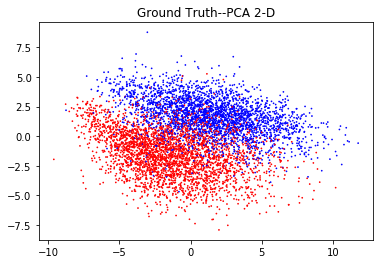

In [18]:
# visualize ground truth in PCA 2-D
plt.scatter(X_std_pca_2d[:, 0], X_std_pca_2d[:, 1], s=0.5, c=color_array), plt.title('Ground Truth--PCA 2-D')
plt.show()

In the 2-D PCA representation of the ground truth, there appear to be clusters each representing center backs and wide backs.  However, there is noticeable intrusion of the two clusters into each other.  Subject to the separation of the data in the higher dimensions, this is likely to cause difficulty in the clustering process because there is not a distinct gap between the clusters.

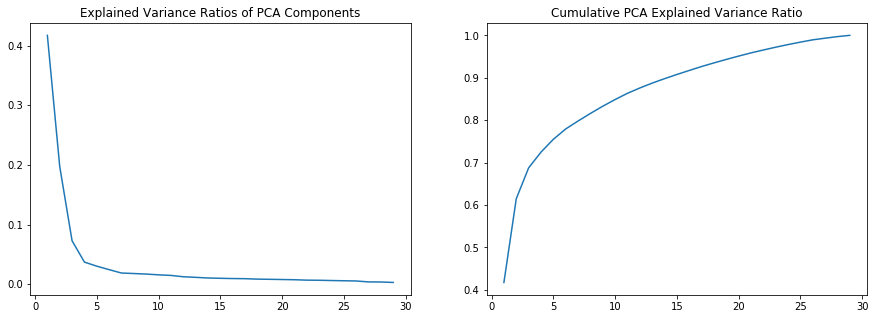

In [19]:
# extract explained variance ratios from PCA object
pca_evr = pca_obj.explained_variance_ratio_

# calculate cumulative explained variance ratio
pca_evr_cumsum = np.cumsum(pca_evr)

# plot explained variance ratios and cumulative explained variance ratio
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(np.nonzero(pca_evr)[0] + 1, pca_evr), plt.title('Explained Variance Ratios of PCA Components')

plt.subplot(1, 2, 2)
plt.plot(np.nonzero(pca_evr)[0] + 1, pca_evr_cumsum), plt.title('Cumulative PCA Explained Variance Ratio')
plt.show()

In [20]:
# print out cumulative explained variance ratio for 1, 2, and 3 PCA components
for n_pca_components in [1, 2, 3]:
    print('Variance explained by ' + str(n_pca_components) + ' PCA components:  ' + \
          str(np.round(pca_evr_cumsum[n_pca_components - 1]*100, 1)) + '%')

Variance explained by 1 PCA components:  41.7%
Variance explained by 2 PCA components:  61.5%
Variance explained by 3 PCA components:  68.7%


It can be seen that the third PCA component explains significantly less variance than the first two components.  The third component is then plotted against the first two components individually to observe whether or not significant separation exists between the ground truth clusters.

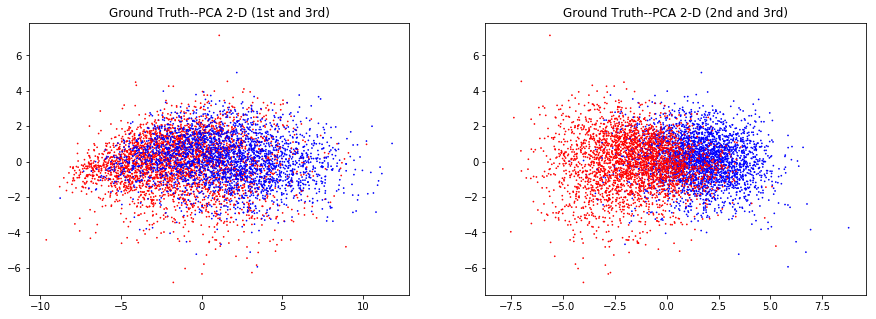

In [21]:
# extract first 3 PCA components for visualization
X_std_pca_3d = pca_obj.transform(X_std)[:, [0, 1, 2]]

# plot first and second PCA components against 3rd PCA component
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_std_pca_3d[:, 0], X_std_pca_3d[:, 2], s=0.5, c=color_array), plt.title('Ground Truth--PCA 2-D (1st and 3rd)')

plt.subplot(1, 2, 2)
plt.scatter(X_std_pca_3d[:, 1], X_std_pca_3d[:, 2], s=0.5, c=color_array), plt.title('Ground Truth--PCA 2-D (2nd and 3rd)')
plt.show()

The first and third PCA components appear to show significantly more overlap between the labeled classes than the first and second PCA components.  The second and third PCA components reveal blended clusters as well, though to a lesser degree.  Regardless, no sharp division between the clusters appear to exist.

## Apply t-SNE

t-SNE is applied to the scaled dataset for visualization to see if it provides clearer resolution between the two labeled class than PCA.

In [22]:
# extract 2-D representation of dataset from t-SNE
X_std_tsne_2d = TSNE().fit_transform(X_std)

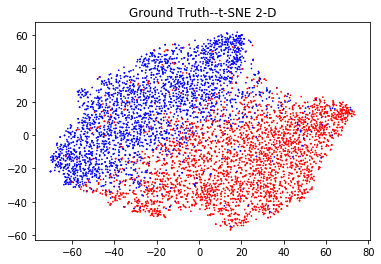

In [23]:
# visualize ground truth in t-SNE 2-D
plt.scatter(X_std_tsne_2d[:, 0], X_std_tsne_2d[:, 1], s=0.5, c=color_array), plt.title('Ground Truth--t-SNE 2-D')
plt.show()

The visualization provided by t-SNE does not appear to provide any significant upgrade on the visualization provided by PCA with labels of each class extending into the bulk cluster of the other class.

## Apply UMAP

UMAP is applied to the scaled dataset for the purpose of visualization of the multidimensional dataset and potential dimensionality reduction.

In [24]:
# extract 2-D representation of dataset from UMAP
X_std_umap_2d = UMAP(n_components=2).fit_transform(X_std)

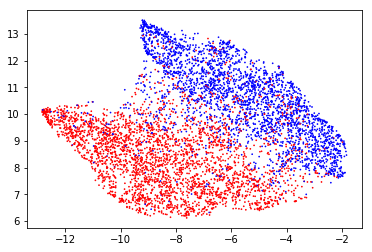

In [25]:
# visualize ground truth in UMAP 2-D
plt.scatter(X_std_umap_2d[:, 0], X_std_umap_2d[:, 1], s=0.5, c=color_array)
plt.show()

The visualization provided by UMAP does not appear to provide any significant upgrade on the visualization provided by PCA with labels of each class extending into the bulk cluster of the other class.

## Proceeding with PCA

Given that t-SNE and UMAP do not appear to provide better visualization in this application, PCA is maintained as the dimensionality reduction technique used for visualization.  The dimensions of the dataset are not reduced at this time, but this option still exists.  Additionally, PCA's ability to account for explained variance in the dataset is maintained.

## Finding 2-cluster solutions

Given that the ground truth is known for this dataset, the amount of clusters is expected to be 2--one for center backs and one for wide backs.  K Means, agglomerative clustering with varying linkage and affinity types, and Gaussian Mixture Models are used to generate 2-cluster solutions.

In [26]:
# list to store identifier for cluster solution
cluster_list = []

# list to store adjusted rand index for cluster solution
cluster_ari_list = []

# list to store silhouette score for cluster solution
cluster_sil_list = []

## K Means 2-cluster solution

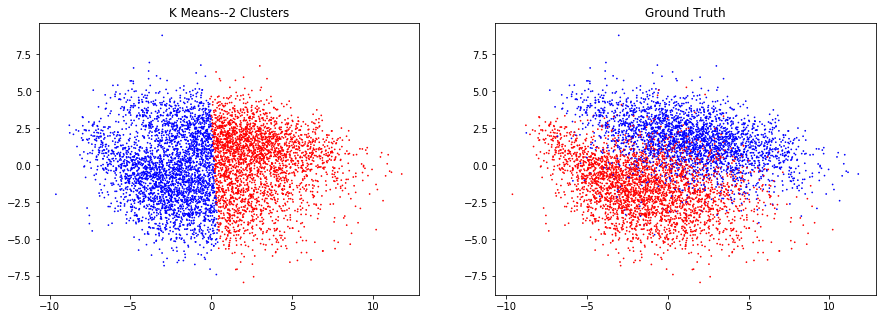

In [27]:
# get class label predictions
kmeans_predict = KMeans(n_clusters=2).fit_predict(X_std)

# calculate silhouette score and adjusted rand index
sil_score = silhouette_score(X_std, kmeans_predict)
ari = adjusted_rand_score(Y, kmeans_predict)

# change colors of plotted points to red and blue
color_array_kmeans = list(map(lambda x: 'r' if x == 1 else 'b', kmeans_predict))

# update lists with K Means entries
cluster_list.append('KMeans--2'), cluster_ari_list.append(ari), cluster_sil_list.append(sil_score)

# plot K Means solution alongside ground truth
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_std_pca_2d[:, 0], X_std_pca_2d[:, 1], s=0.5, c=color_array_kmeans), plt.title('K Means--2 Clusters')

plt.subplot(1, 2, 2)
plt.scatter(X_std_pca_2d[:, 0], X_std_pca_2d[:, 1], s=0.5, c=color_array), plt.title('Ground Truth')
plt.show()

The PCA 2-D representation of the K Means 2-cluster solution demonstrates a significant departure from the PCA 2-D representation of the ground truth.

## Agglomerative clustering 2-cluster solution with Ward linkage and Euclidean affinity

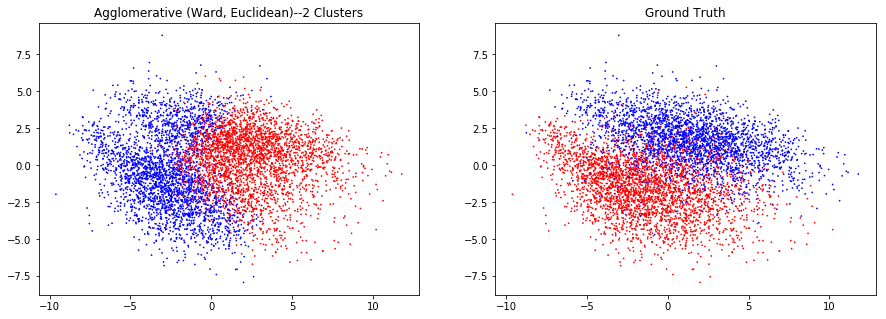

In [28]:
# get class label predictions
agglom_predict = AgglomerativeClustering(n_clusters=2, linkage='ward', affinity='euclidean').fit_predict(X_std)

# calculate silhouette score and adjusted rand index
sil_score = silhouette_score(X_std, agglom_predict)
ari = adjusted_rand_score(Y, agglom_predict)

# change colors of plotted points to red and blue
color_array_agglom = list(map(lambda x: 'r' if x == 1 else 'b', agglom_predict))

# update lists with cluster entries
cluster_list.append('Agglomerative (Ward, Euclidiean)--2'), cluster_ari_list.append(ari), cluster_sil_list.append(sil_score)

# plot cluster solution alongside ground truth
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_std_pca_2d[:, 0], X_std_pca_2d[:, 1], s=0.5, c=color_array_agglom)
plt.title('Agglomerative (Ward, Euclidean)--2 Clusters')

plt.subplot(1, 2, 2)
plt.scatter(X_std_pca_2d[:, 0], X_std_pca_2d[:, 1], s=0.5, c=color_array), plt.title('Ground Truth')
plt.show()

The PCA 2-D representation of the agglomerative (Ward, Euclidean) 2-cluster solution demonstrates a significant departure from the PCA 2-D representation of the ground truth.

## Agglomerative clustering 2-cluster solution with Average linkage and Euclidean affinity

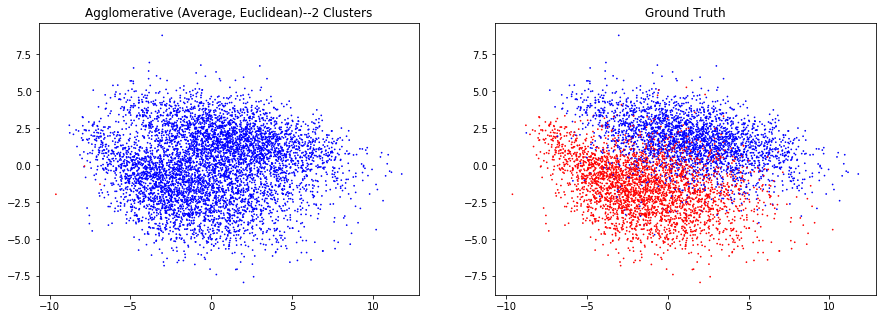

In [29]:
# get class label predictions
agglom_predict = AgglomerativeClustering(n_clusters=2, linkage='average', affinity='euclidean').fit_predict(X_std)

# calculate silhouette score and adjusted rand index
sil_score = silhouette_score(X_std, agglom_predict)
ari = adjusted_rand_score(Y, agglom_predict)

# change colors of plotted points to red and blue
color_array_agglom = list(map(lambda x: 'r' if x == 1 else 'b', agglom_predict))

# update lists with cluster entries
cluster_list.append('Agglomerative (Average, Euclidiean)--2'), cluster_ari_list.append(ari), cluster_sil_list.append(sil_score)

# plot cluster solution alongside ground truth
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_std_pca_2d[:, 0], X_std_pca_2d[:, 1], s=0.5, c=color_array_agglom)
plt.title('Agglomerative (Average, Euclidean)--2 Clusters')

plt.subplot(1, 2, 2)
plt.scatter(X_std_pca_2d[:, 0], X_std_pca_2d[:, 1], s=0.5, c=color_array), plt.title('Ground Truth')
plt.show()

The PCA 2-D representation of the agglomerative (Average, Euclidean) 2-cluster solution demonstrates a significant departure from the PCA 2-D representation of the ground truth.  It is worth noting that this solution has one class that has almost all  of the observations, which is even further not in line with the ground truth.

## Agglomerative clustering 2-cluster solution with Average linkage and Manhattan affinity

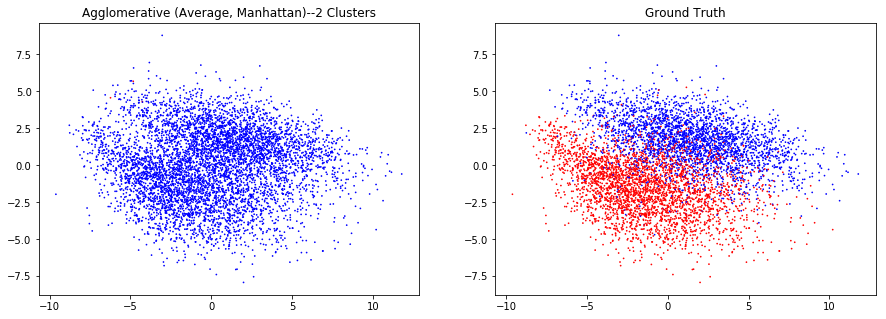

In [30]:
# get class label predictions
agglom_predict = AgglomerativeClustering(n_clusters=2, linkage='average', affinity='manhattan').fit_predict(X_std)

# calculate silhouette score and adjusted rand index
sil_score = silhouette_score(X_std, agglom_predict)
ari = adjusted_rand_score(Y, agglom_predict)

# change colors of plotted points to red and blue
color_array_agglom = list(map(lambda x: 'r' if x == 1 else 'b', agglom_predict))

# update lists with cluster entries
cluster_list.append('Agglomerative (Average, Manhattan)--2'), cluster_ari_list.append(ari), cluster_sil_list.append(sil_score)

# plot cluster solution alongside ground truth
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_std_pca_2d[:, 0], X_std_pca_2d[:, 1], s=0.5, c=color_array_agglom)
plt.title('Agglomerative (Average, Manhattan)--2 Clusters')

plt.subplot(1, 2, 2)
plt.scatter(X_std_pca_2d[:, 0], X_std_pca_2d[:, 1], s=0.5, c=color_array), plt.title('Ground Truth')
plt.show()

The PCA 2-D representation of the agglomerative (Average, Manhattan) 2-cluster solution demonstrates a significant departure from the PCA 2-D representation of the ground truth.  It is worth noting that this solution has one class that has almost all  of the observations, which is even further not in line with the ground truth.

## Agglomerative clustering 2-cluster solution with Average linkage and Cosine affinity

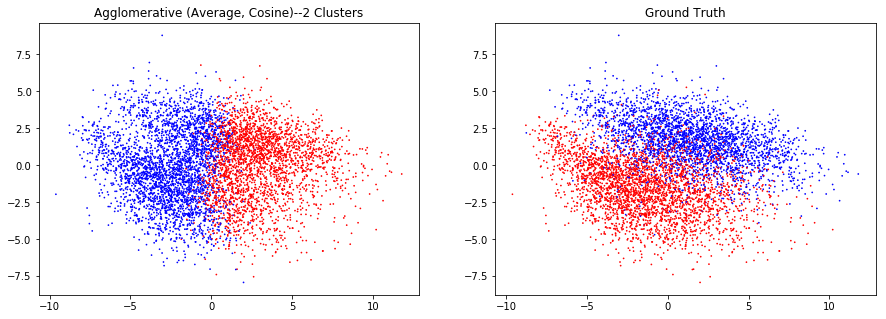

In [31]:
# get class label predictions
agglom_predict = AgglomerativeClustering(n_clusters=2, linkage='average', affinity='cosine').fit_predict(X_std)

# calculate silhouette score and adjusted rand index
sil_score = silhouette_score(X_std, agglom_predict)
ari = adjusted_rand_score(Y, agglom_predict)

# change colors of plotted points to red and blue
color_array_agglom = list(map(lambda x: 'r' if x == 1 else 'b', agglom_predict))

# update lists with cluster entries
cluster_list.append('Agglomerative (Average, Cosine)--2'), cluster_ari_list.append(ari), cluster_sil_list.append(sil_score)

# plot cluster solution alongside ground truth
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_std_pca_2d[:, 0], X_std_pca_2d[:, 1], s=0.5, c=color_array_agglom)
plt.title('Agglomerative (Average, Cosine)--2 Clusters')

plt.subplot(1, 2, 2)
plt.scatter(X_std_pca_2d[:, 0], X_std_pca_2d[:, 1], s=0.5, c=color_array), plt.title('Ground Truth')
plt.show()

The PCA 2-D representation of the agglomerative (Average, Cosine) 2-cluster solution demonstrates a significant departure from the PCA 2-D representation of the ground truth.

## Agglomerative clustering 2-cluster solution with Complete linkage and Euclidean affinity

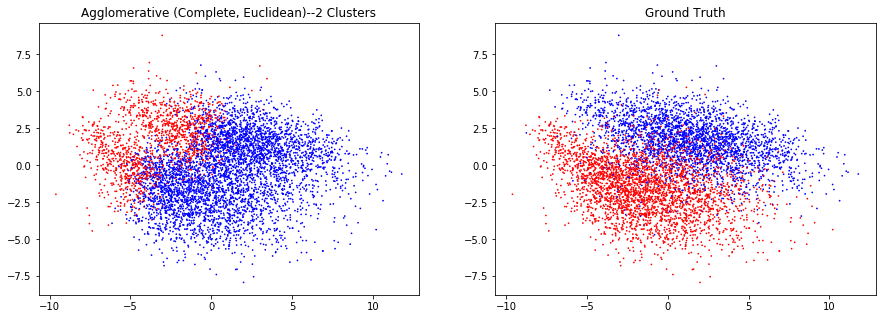

In [32]:
# get class label predictions
agglom_predict = AgglomerativeClustering(n_clusters=2, linkage='complete', affinity='euclidean').fit_predict(X_std)

# calculate silhouette score and adjusted rand index
sil_score = silhouette_score(X_std, agglom_predict)
ari = adjusted_rand_score(Y, agglom_predict)

# change colors of plotted points to red and blue
color_array_agglom = list(map(lambda x: 'r' if x == 1 else 'b', agglom_predict))

# update lists with cluster entries
cluster_list.append('Agglomerative (Complete, Euclidiean)--2'), cluster_ari_list.append(ari), cluster_sil_list.append(sil_score)

# plot cluster solution alongside ground truth
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_std_pca_2d[:, 0], X_std_pca_2d[:, 1], s=0.5, c=color_array_agglom)
plt.title('Agglomerative (Complete, Euclidean)--2 Clusters')

plt.subplot(1, 2, 2)
plt.scatter(X_std_pca_2d[:, 0], X_std_pca_2d[:, 1], s=0.5, c=color_array), plt.title('Ground Truth')
plt.show()

The PCA 2-D representation of the agglomerative (Complete, Euclidean) 2-cluster solution demonstrates a significant departure from the PCA 2-D representation of the ground truth.

## Agglomerative clustering 2-cluster solution with Complete linkage and Manhattan affinity

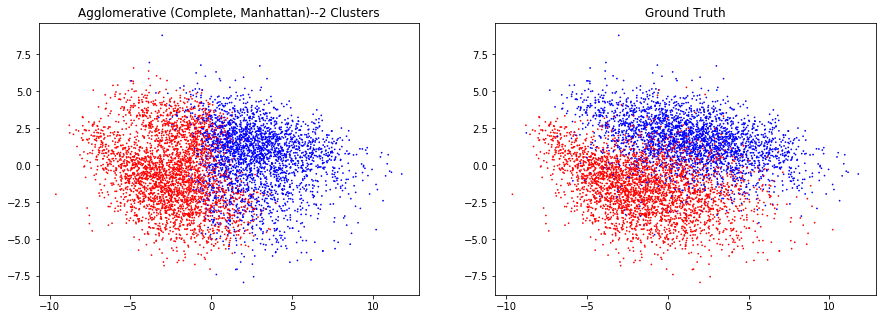

In [33]:
# get class label predictions
agglom_predict = AgglomerativeClustering(n_clusters=2, linkage='complete', affinity='manhattan').fit_predict(X_std)

# calculate silhouette score and adjusted rand index
sil_score = silhouette_score(X_std, agglom_predict)
ari = adjusted_rand_score(Y, agglom_predict)

# change colors of plotted points to red and blue
color_array_agglom = list(map(lambda x: 'r' if x == 1 else 'b', agglom_predict))

# update lists with cluster entries
cluster_list.append('Agglomerative (Complete, Manhattan)--2'), cluster_ari_list.append(ari), cluster_sil_list.append(sil_score)

# plot cluster solution alongside ground truth
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_std_pca_2d[:, 0], X_std_pca_2d[:, 1], s=0.5, c=color_array_agglom)
plt.title('Agglomerative (Complete, Manhattan)--2 Clusters')

plt.subplot(1, 2, 2)
plt.scatter(X_std_pca_2d[:, 0], X_std_pca_2d[:, 1], s=0.5, c=color_array), plt.title('Ground Truth')
plt.show()

The PCA 2-D representation of the agglomerative (Complete, Manhattan) 2-cluster solution demonstrates a significant departure from the PCA 2-D representation of the ground truth.

## Agglomerative clustering 2-cluster solution with Complete linkage and Cosine affinity

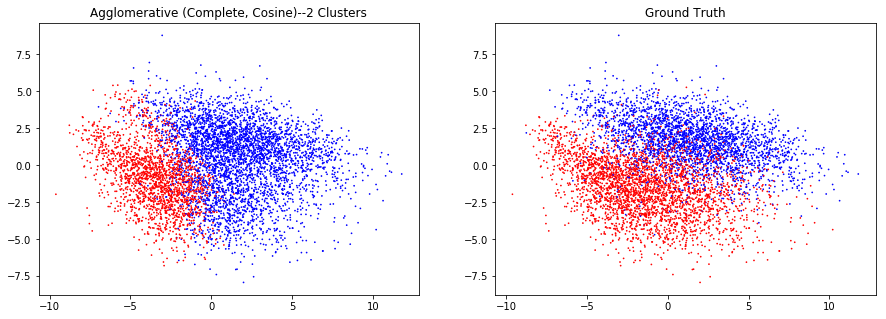

In [34]:
# get class label predictions
agglom_predict = AgglomerativeClustering(n_clusters=2, linkage='complete', affinity='cosine').fit_predict(X_std)

# calculate silhouette score and adjusted rand index
sil_score = silhouette_score(X_std, agglom_predict)
ari = adjusted_rand_score(Y, agglom_predict)

# change colors of plotted points to red and blue
color_array_agglom = list(map(lambda x: 'r' if x == 1 else 'b', agglom_predict))

# update lists with cluster entries
cluster_list.append('Agglomerative (Complete, Cosine)--2'), cluster_ari_list.append(ari), cluster_sil_list.append(sil_score)

# plot cluster solution alongside ground truth
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_std_pca_2d[:, 0], X_std_pca_2d[:, 1], s=0.5, c=color_array_agglom)
plt.title('Agglomerative (Complete, Cosine)--2 Clusters')

plt.subplot(1, 2, 2)
plt.scatter(X_std_pca_2d[:, 0], X_std_pca_2d[:, 1], s=0.5, c=color_array), plt.title('Ground Truth')
plt.show()

The PCA 2-D representation of the agglomerative (Complete, Cosine) 2-cluster solution demonstrates a significant departure from the PCA 2-D representation of the ground truth.

## Gaussian Mixture Modeling 2-cluster solution

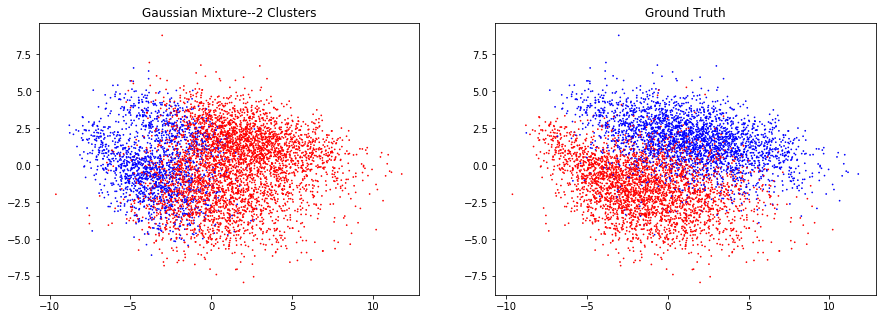

In [35]:
# get class label predictions
gmm_predict = GMM(n_components=2).fit_predict(X_std)

# calculate silhouette score and adjusted rand index
sil_score = silhouette_score(X_std, gmm_predict)
ari = adjusted_rand_score(Y, gmm_predict)

# change colors of plotted points to red and blue
color_array_gmm = list(map(lambda x: 'r' if x == 1 else 'b', gmm_predict))

# update lists with cluster entries
cluster_list.append('GMM--2'), cluster_ari_list.append(ari), cluster_sil_list.append(sil_score)

# plot cluster solution alongside ground truth
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_std_pca_2d[:, 0], X_std_pca_2d[:, 1], s=0.5, c=color_array_gmm)
plt.title('Gaussian Mixture--2 Clusters')

plt.subplot(1, 2, 2)
plt.scatter(X_std_pca_2d[:, 0], X_std_pca_2d[:, 1], s=0.5, c=color_array), plt.title('Ground Truth')
plt.show()

The PCA 2-D representation of the Gaussian Mixture Modeling 2-cluster solution demonstrates a significant departure from the PCA 2-D representation of the ground truth.

## DBSCAN clustering

DBSCAN clustering was attempted but not included in this notebook due to the inability to locate distinct clusters with how the observations in the two ground truth groups are mingled with each other.

## Summarize and evaluate 2-cluster results

None of the 2-cluster solutions appear to demonstrate a good fit to the ground truth based on the 2-D PCA representations of the labeled observations.  Using the adjusted rand indices and silhouette scores for each of the 2-cluster solutions, a DataFrame is created that summarizes the results.

In [36]:
df_2_cluster_results = pd.DataFrame(index=cluster_list, data={'ARI': cluster_ari_list, 'Silhouette Score': cluster_sil_list})
df_2_cluster_results

,ARI,Silhouette Score
KMeans--2,0.128982,0.232347
"Agglomerative (Ward, Euclidiean)--2",0.133689,0.201734
"Agglomerative (Average, Euclidiean)--2",-0.000102,0.295456
"Agglomerative (Average, Manhattan)--2",0.000115,0.255323
"Agglomerative (Average, Cosine)--2",0.084802,0.219534
"Agglomerative (Complete, Euclidiean)--2",0.003443,0.143409
"Agglomerative (Complete, Manhattan)--2",0.177431,0.206810
"Agglomerative (Complete, Cosine)--2",0.195481,0.193049
GMM--2,0.029100,0.149178


In [37]:
# print max ARI of 2-cluster solutions
print('Maximum ARI of 2-cluster solutions:  ' + str(df_2_cluster_results['ARI'].max()))

# print max silhouette score of 2-cluster solutions
print('Maximum silhouette score of 2-cluster solutions:  ' + str(df_2_cluster_results['Silhouette Score'].max()))

Maximum ARI of 2-cluster solutions:  0.19548127263651077
Maximum silhouette score of 2-cluster solutions:  0.29545610643707604


The ARIs for most of the 2-cluster solutions are barely distinguishable from a random assignment of labels.  The best ARI is less than 0.2, which is still not a very good ARI.  Additionally, the silhouette scores do not indicate well-separated clusters, either.  This supports the visual observations from the 2-D PCA visualizations.

## Relative performance of reduced-dimension datasets

Performing clustering with all 29 attributes in the dataset requires more computing time than using a dimensionally-reduced dataset.  For this reason, K Means clustering (2 clusters) is performed with the datasets resulting from PCA with a range of 1 to 29 dimensions to observe the impact on cluster performance.

In [38]:
# create lists to store information for each iteration
n_components_list = []
ARI_list = []
sil_score_list = []

for n_components in range(1, X_std.shape[1] + 1):
    
    # get first n_components PCA components
    X_std_pca = pca_obj.transform(X_std)[:, list(range(n_components))]
    
    # get class labels for 2-cluster K Means solution
    kmeans_predict = KMeans(n_clusters=2).fit_predict(X_std_pca)
    
    # calculate silhouette score and adjusted rand index
    sil_score = silhouette_score(X_std_pca, kmeans_predict)
    ari = adjusted_rand_score(Y, kmeans_predict)
    
    # add new entries to lists
    n_components_list.append(n_components), ARI_list.append(ari), sil_score_list.append(sil_score)

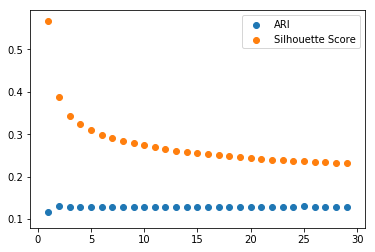

In [39]:
# create DataFrame summarizing cluster evaluation statistics
df_2_cluster_pca_results = pd.DataFrame(index=n_components_list, data={'ARI': ARI_list, 'Silhouette Score': sil_score_list})

# plot the results
plt.scatter(df_2_cluster_pca_results.index, df_2_cluster_pca_results['ARI'])
plt.scatter(df_2_cluster_pca_results.index, df_2_cluster_pca_results['Silhouette Score'])
plt.legend(['ARI', 'Silhouette Score'])
plt.show()

Given that the clusters were made by incrementally adding dimensions with less explained variance, the silhouette scores unsurprisingly decreased with added PCA components.  However, the adjusted rand indices achieved by the clusters with varying numbers of PCA components varied very little.

## Exploring alternate number of clusters

Since the class labels are known for this dataset, the number of expected is clusters is known to be 2.  However, the clustering methods attempted are observed not to be able to cluster this dataset well.  The next consideration is that the two classes could be better represented by a larger number of classes that are subclasses of the original classes.  Therefore, clustering solutions with more than 2 clusters are attempted to observe performance.  Additional clusters can provide resolution that the 2-cluster solution could not provide.  Initially, clustering solutions from 3 to 10 clusters are attempted using the same methods as attempted for the 2-cluster solutions.  In these clusters, the original number of clusters are combined in each possible way, and the grouping of clusters that yields the best ARI is saved for that number of clusters.  In this way, a clustering solution with 3 to 10 clusters is condensed to a 2-cluster by virtue of combining the original clusters.

## K Means 3 to 10 clusters

In [40]:
# set range of clusters to test
min_clusters = 3
max_clusters = 10

# create lists to store entries for different cluster numbers
max_ARI_list = []
n_max_ARI_list = []
max_ARI_cluster_group_list = []

# cycle through cluster solutions
for n_clusters in range(min_clusters, max_clusters + 1):
    # create variables to hold information for best performing clusters
    max_ARI = None
    max_ARI_cluster_group = None
    # get class labels for cluster solution
    kmeans_predict = KMeans(n_clusters=n_clusters).fit_predict(X_std)
    # cycle through each combination of clusters
    for n_group_clusters in range(min_clusters - 1, n_clusters):
        for cluster_group in combinations(set(kmeans_predict), n_group_clusters):
            # get class labels for condensed cluster solution
            kmeans_predict_mod = list(map(lambda x: 1 if x in cluster_group else 0, kmeans_predict))
            # calculate ARI for condensed cluster solution
            ari = adjusted_rand_score(Y, kmeans_predict_mod)
            # save ARI if it is the highest observed
            if (max_ARI == None):
                max_ARI = ari
                max_ARI_cluster_group = ','.join([str(x) for x in cluster_group])
            else:
                if (ari > max_ARI):
                    max_ARI = ari
                    max_ARI_cluster_group = ','.join([str(x) for x in cluster_group])
    # add entries to lists for number of clusters
    n_max_ARI_list.append(n_clusters)
    max_ARI_list.append(max_ARI)
    max_ARI_cluster_group_list.append(max_ARI_cluster_group)
    
# create DataFrame to summarize ARIs for different numbers of clusters
df_max_ARI = pd.DataFrame(data={'Number of Clusters': n_max_ARI_list, 'K Means': max_ARI_list})

## Agglomerative clustering 3 to 10 clusters

In [41]:
# cycle through linkage types
for linkage in ['ward', 'average', 'complete']:
    # cycle through affinity types
    for affinity in ['euclidean', 'manhattan', 'cosine']:
        if (linkage == 'ward' and affinity != 'euclidean'):
            pass
        else:
            # create lists to store entries for different cluster numbers
            max_ARI_list = []
            max_ARI_cluster_group_list = []
            # cycle through cluster solutions
            for n_clusters in range(min_clusters, max_clusters + 1):        
                # create variables to hold information for best performing clusters
                max_ARI = None
                max_ARI_cluster_group = None
                # get class labels for cluster solution
                agglom_predict = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage, affinity=affinity)\
                .fit_predict(X_std)
                # cycle through each combination of clusters
                for n_group_clusters in range(min_clusters - 1, n_clusters):
                    for cluster_group in combinations(set(agglom_predict), n_group_clusters):
                        # get class labels for condensed cluster solution
                        agglom_predict_mod = list(map(lambda x: 1 if x in cluster_group else 0, agglom_predict))
                        # calculate ARI for condensed cluster solution
                        ari = adjusted_rand_score(Y, agglom_predict_mod)
                        # save ARI if it is the highest observed
                        if (max_ARI == None):
                            max_ARI = ari
                            max_ARI_cluster_group = ','.join([str(x) for x in cluster_group])
                        else:
                            if (ari > max_ARI):
                                max_ARI = ari
                                max_ARI_cluster_group = ','.join([str(x) for x in cluster_group])
                # add entries to lists for number of clusters
                max_ARI_list.append(max_ARI)
                max_ARI_cluster_group_list.append(max_ARI_cluster_group)
            # add agglomerative clustering results to summary DataFrames
            df_max_ARI['Agglom ' + linkage + '_' + affinity] = max_ARI_list

## GMM clustering 3 to 10 clusters

In [42]:
# create lists to store entries for different cluster numbers
max_ARI_list = []
max_ARI_cluster_group_list = []
# cycle through cluster solutions
for n_clusters in range(min_clusters, max_clusters + 1):
    # create variables to hold information for best performing clusters
    max_ARI = None
    max_ARI_cluster_group = None
    # get class labels for cluster solution
    gmm_predict = GMM(n_components=n_clusters).fit_predict(X_std)
    # cycle through each combination of clusters
    for n_group_clusters in range(min_clusters - 1, n_clusters):
        for cluster_group in combinations(set(gmm_predict), n_group_clusters):
            # get class labels for condensed cluster solution
            gmm_predict_mod = list(map(lambda x: 1 if x in cluster_group else 0, gmm_predict))
            # calculate ARI for condensed cluster solution
            ari = adjusted_rand_score(Y, gmm_predict_mod)
            # save ARI if it is the highest observed
            if (max_ARI == None):
                max_ARI = ari
                max_ARI_cluster_group = ','.join([str(x) for x in cluster_group])
            else:
                if (ari > max_ARI):
                    max_ARI = ari
                    max_ARI_cluster_group = ','.join([str(x) for x in cluster_group])
    # add entries to lists for number of clusters
    max_ARI_list.append(max_ARI)
    max_ARI_cluster_group_list.append(max_ARI_cluster_group)
# add GMM clustering results to summary DataFrame
df_max_ARI['GMM'] = max_ARI_list

## Evaluate condensed cluster solutions from alternate number of original clusters

Unsurprisingly, increasing ARIs are observed with increasing numbers of original clusters used to create the condensed cluster solutions.  Some clustering methods perform better than others.  It is observed that K Means, some types of agglomerative clustering, and GMM provide better ARIs than others.  The worst-performing models are types of agglomerative clustering.

In [43]:
df_max_ARI

,Number of Clusters,K Means,Agglom ward_euclidean,Agglom average_euclidean,Agglom average_manhattan,Agglom average_cosine,Agglom complete_euclidean,Agglom complete_manhattan,Agglom complete_cosine,GMM
0,3,0.258510,0.133689,0.000285,0.000446,0.315059,0.042651,0.177431,0.348855,0.326251
1,4,0.453337,0.133689,0.000285,0.203319,0.316217,0.042651,0.177431,0.348855,0.481282
2,5,0.456085,0.344463,0.000325,0.203319,0.316217,0.273602,0.241199,0.348855,0.625615
3,6,0.585285,0.454677,0.000325,0.239884,0.316217,0.273602,0.241199,0.348855,0.652328
4,7,0.605811,0.584229,0.276600,0.239884,0.553378,0.483666,0.241199,0.530786,0.537216
5,8,0.591563,0.584229,0.277317,0.239884,0.556427,0.483666,0.342988,0.530786,0.628842
6,9,0.619159,0.584229,0.277317,0.240219,0.556936,0.525826,0.353853,0.530786,0.604744
7,10,0.619695,0.584229,0.277317,0.240219,0.568192,0.525826,0.353853,0.540768,0.591566


The clustering methods that do not achieve an ARI equal to or greater than 0.5 among any of the number of clusters are removed.  Additionally, the GMM clustering method is observed to be volatile without the expected trend of increasing ARI with increasing number of clusters.  Therefore, it is also dropped.

In [44]:
# remove columns that do not achieve ARI equal to or greater than 0.5
df_max_ARI_cols_to_drop = []
for col_name in df_max_ARI.columns:
    if (col_name == 'Number of Clusters'):
        pass
    else:
        if (df_max_ARI[col_name].max() < 0.5):
            df_max_ARI_cols_to_drop.append(col_name)
df_max_ARI2 = df_max_ARI.drop(columns=df_max_ARI_cols_to_drop)

In [45]:
# remove GMM
df_max_ARI3 = df_max_ARI2.drop(columns=['GMM'])

In [46]:
df_max_ARI3

,Number of Clusters,K Means,Agglom ward_euclidean,Agglom average_cosine,Agglom complete_euclidean,Agglom complete_cosine
0,3,0.258510,0.133689,0.315059,0.042651,0.348855
1,4,0.453337,0.133689,0.316217,0.042651,0.348855
2,5,0.456085,0.344463,0.316217,0.273602,0.348855
3,6,0.585285,0.454677,0.316217,0.273602,0.348855
4,7,0.605811,0.584229,0.553378,0.483666,0.530786
5,8,0.591563,0.584229,0.556427,0.483666,0.530786
6,9,0.619159,0.584229,0.556936,0.525826,0.530786
7,10,0.619695,0.584229,0.568192,0.525826,0.540768


The ARIs for each clustering method are plotted to show the change in ARI with increasing number of original clusters.

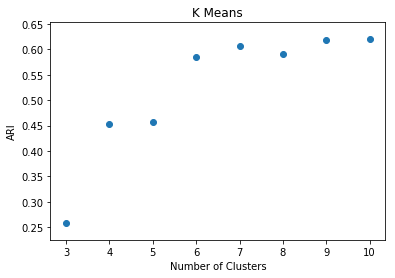

In [47]:
# plot ARIs for condensed cluster K Means solutions
plt.scatter(x=df_max_ARI2['Number of Clusters'], y=df_max_ARI2['K Means'])
plt.title('K Means'), plt.xlabel('Number of Clusters'), plt.ylabel('ARI')
plt.show()

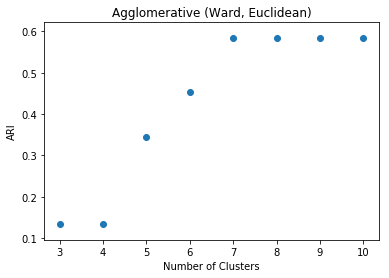

In [48]:
# plot ARIs for condensed cluster Agglomerative (Ward, Euclidean) solutions
plt.scatter(x=df_max_ARI2['Number of Clusters'], y=df_max_ARI2['Agglom ward_euclidean'])
plt.title('Agglomerative (Ward, Euclidean)'), plt.xlabel('Number of Clusters'), plt.ylabel('ARI')
plt.show()

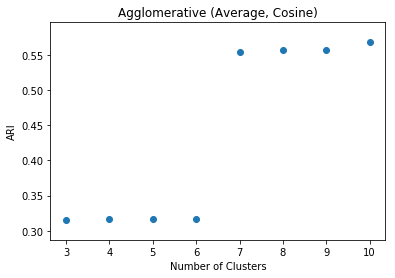

In [49]:
# plot ARIs for condensed cluster Agglomerative (Average, Cosine) solutions
plt.scatter(x=df_max_ARI2['Number of Clusters'], y=df_max_ARI2['Agglom average_cosine'])
plt.title('Agglomerative (Average, Cosine)'), plt.xlabel('Number of Clusters'), plt.ylabel('ARI')
plt.show()

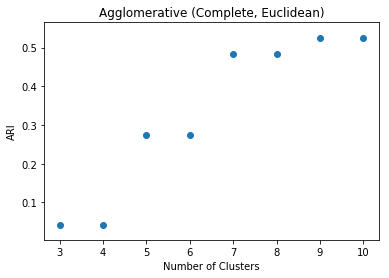

In [50]:
# plot ARIs for condensed cluster Agglomerative (Complete, Euclidean) solutions
plt.scatter(x=df_max_ARI2['Number of Clusters'], y=df_max_ARI2['Agglom complete_euclidean'])
plt.title('Agglomerative (Complete, Euclidean)'), plt.xlabel('Number of Clusters'), plt.ylabel('ARI')
plt.show()

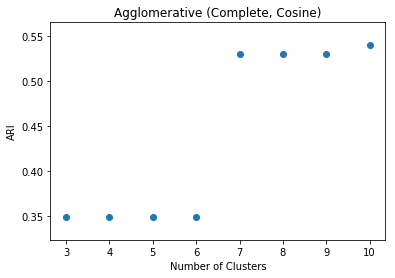

In [51]:
# plot ARIs for condensed cluster Agglomerative (Complete, Cosine) solutions
plt.scatter(x=df_max_ARI2['Number of Clusters'], y=df_max_ARI2['Agglom complete_cosine'])
plt.title('Agglomerative (Complete, Cosine)'), plt.xlabel('Number of Clusters'), plt.ylabel('ARI')
plt.show()

Across the different type of clustering methods, it appears that the gain in performance plateaus beyond 7 original clusters.  Therefore, this is selected to be the number of clusters sought for the dataset.  Given that K Means was the best performing of the remaining clustering techniques, it is used for creation of the 7-cluster solution.

## K Means 7-cluster solution

A 7-cluster K Means solution is created.  From this 7-cluster solution, a condensed cluster solution is created that optimizes the ARI.  Using the 2-D PCA representation of the dataset, visualizations are created to compare the 7-cluster solution, condensed cluster solution, and the ground truth.

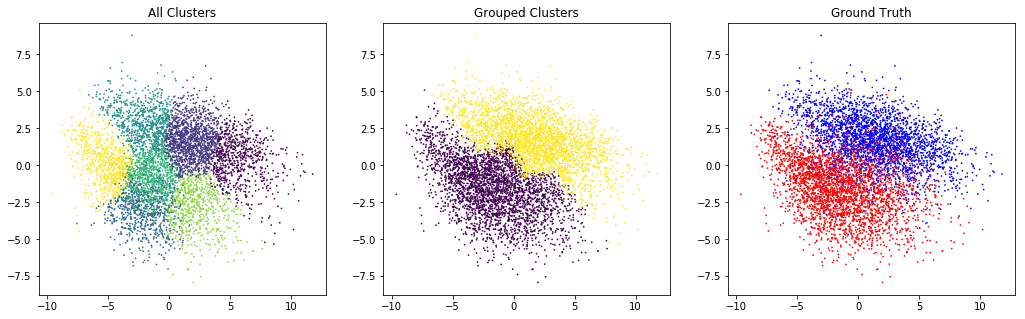

In [52]:
# get class labels for 7-cluster solution
kmeans_fit = KMeans(n_clusters=7, random_state=12).fit(X_std)
kmeans_predict = kmeans_fit.predict(X_std)

plt.figure(figsize=(17.5, 5))

# plot 7-cluster solution
plt.subplot(1, 3, 1)
plt.scatter(X_std_pca_2d[:, 0], X_std_pca_2d[:, 1], s=0.5, c=kmeans_predict), plt.title('All Clusters')

# determine optimal condensed cluster solution as seen before
max_ARI = None
max_ARI_cluster_group = None
for n_group_clusters in range(1, 7):
        for cluster_group in combinations(set(kmeans_predict), n_group_clusters):
            kmeans_predict_mod = list(map(lambda x: 1 if x in cluster_group else 0, kmeans_predict))
            ari = adjusted_rand_score(Y, kmeans_predict_mod)
            if (max_ARI == None):
                max_ARI = ari
                max_ARI_cluster_group = list(cluster_group)
            else:
                if (ari > max_ARI):
                    max_ARI = ari
                    max_ARI_cluster_group = list(cluster_group)

# get class labels for optimal condensed cluster solution
kmeans_predict_mod_best = list(map(lambda x: 1 if x in max_ARI_cluster_group else 0, kmeans_predict))

# plot condensed cluster solution
plt.subplot(1, 3, 2)
plt.scatter(X_std_pca_2d[:, 0], X_std_pca_2d[:, 1], s=0.5, c=kmeans_predict_mod_best), plt.title('Grouped Clusters')

# plot ground truth
plt.subplot(1, 3, 3)
plt.scatter(X_std_pca_2d[:, 0], X_std_pca_2d[:, 1], s=0.5, c=color_array), plt.title('Ground Truth')
plt.show()

Unlike the 2-cluster solutions, the optimal condensed cluster solution from the 7-cluster solution shows relatively good agreement with the ground truth.  The condensed cluster solution is not able to account for the mixing of the clusters that occurs in the ground truth but the cluster shapes are generally the same.

In [53]:
print('The ARI of the condensed cluster solution is ' + str(np.round(max_ARI, 2)) + '.')

The ARI of the condensed cluster solution is 0.61.


The ARI of the condensed cluster solution is a significant improvement on the ARIs achieved by the 2-cluster solutions.  Granted, it was optimized in a manner similar to supervised learning.  However, this clustering solution has useful information to offer in the form of the characteristics of the component clusters.  Since the 2-cluster solutions were unable to provide satisfactory clusters when compared with the ground truth, it is reasonable to suggest that there are clusters that, when grouped, manifest as the center back and wide back clusters.

## Characterizing clusters

In [54]:
df7 = df6.copy()

# add column that identifies to which of the 7 clusters the observations were assigned
df7['Cluster Assignment'] = kmeans_predict

# add column that identifies to which of the 2 condensed clusters the observations were assigned
df7['Grouped Cluster Assignment'] = kmeans_predict_mod_best
df7.head()

,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,IsCB,Cluster Assignment,Grouped Cluster Assignment
0,66.0,60.0,91.0,78.0,66.0,63.0,74.0,72.0,77.0,84.0,76.0,75.0,78.0,85.0,66.0,79.0,93.0,84.0,83.0,59.0,88.0,90.0,60.0,63.0,75.0,82.0,87.0,92.0,91.0,1,0,1
1,55.0,42.0,92.0,79.0,47.0,53.0,49.0,51.0,70.0,76.0,68.0,68.0,58.0,85.0,54.0,67.0,91.0,66.0,88.0,43.0,89.0,88.0,48.0,52.0,50.0,82.0,90.0,89.0,89.0,1,5,0
2,58.0,33.0,83.0,59.0,45.0,58.0,60.0,31.0,59.0,57.0,63.0,75.0,54.0,82.0,55.0,78.0,89.0,65.0,89.0,49.0,92.0,88.0,28.0,50.0,50.0,84.0,93.0,93.0,90.0,1,5,0
3,64.0,55.0,87.0,81.0,60.0,68.0,65.0,53.0,85.0,81.0,53.0,64.0,63.0,87.0,60.0,71.0,68.0,66.0,84.0,51.0,69.0,92.0,56.0,79.0,68.0,91.0,88.0,90.0,88.0,1,0,1
4,90.0,70.0,75.0,84.0,54.0,90.0,85.0,67.0,76.0,92.0,83.0,82.0,86.0,88.0,86.0,83.0,76.0,91.0,78.0,70.0,84.0,85.0,85.0,82.0,59.0,86.0,71.0,85.0,86.0,0,0,1


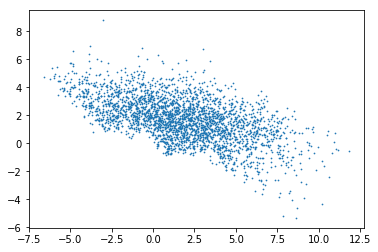

In [55]:
# visualize observations with class label 1 in condensed cluster solution
gca_1_index = df7[df7['Grouped Cluster Assignment'] == 1].index.values
plt.scatter(X_std_pca_2d[gca_1_index, 0], X_std_pca_2d[gca_1_index, 1], s=0.5)
plt.show()

Comparison of the visualization above with the ground truth shows that the condensed cluster solution with a class label of 1 corresponds to the wide back class.  Since the 'IsCB' label is equal to 1 to indicate the center back class, the class labels of the condensed cluster solution are switched so that they align with the ground truth.

In [56]:
df7.drop(columns=['Grouped Cluster Assignment'], inplace=True)
df7['Grouped Cluster Assignment'] = list(map(lambda x: 1 if x == 0 else 0, kmeans_predict_mod_best))
df7.head()

,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,IsCB,Cluster Assignment,Grouped Cluster Assignment
0,66.0,60.0,91.0,78.0,66.0,63.0,74.0,72.0,77.0,84.0,76.0,75.0,78.0,85.0,66.0,79.0,93.0,84.0,83.0,59.0,88.0,90.0,60.0,63.0,75.0,82.0,87.0,92.0,91.0,1,0,0
1,55.0,42.0,92.0,79.0,47.0,53.0,49.0,51.0,70.0,76.0,68.0,68.0,58.0,85.0,54.0,67.0,91.0,66.0,88.0,43.0,89.0,88.0,48.0,52.0,50.0,82.0,90.0,89.0,89.0,1,5,1
2,58.0,33.0,83.0,59.0,45.0,58.0,60.0,31.0,59.0,57.0,63.0,75.0,54.0,82.0,55.0,78.0,89.0,65.0,89.0,49.0,92.0,88.0,28.0,50.0,50.0,84.0,93.0,93.0,90.0,1,5,1
3,64.0,55.0,87.0,81.0,60.0,68.0,65.0,53.0,85.0,81.0,53.0,64.0,63.0,87.0,60.0,71.0,68.0,66.0,84.0,51.0,69.0,92.0,56.0,79.0,68.0,91.0,88.0,90.0,88.0,1,0,0
4,90.0,70.0,75.0,84.0,54.0,90.0,85.0,67.0,76.0,92.0,83.0,82.0,86.0,88.0,86.0,83.0,76.0,91.0,78.0,70.0,84.0,85.0,85.0,82.0,59.0,86.0,71.0,85.0,86.0,0,0,0


In order to see how well the condensed clustering solution performs across the two classes, a contingency table is created.  Additionally, the accuracy for each class be correctly labeled according to the grouth truth is calculated. 

In [57]:
ct = pd.crosstab(df7['IsCB'], df7['Grouped Cluster Assignment'])
ct

Grouped Cluster Assignment,0,1
IsCB,,
0,2478,300
1,351,2737


In [58]:
print('Accuracy:  ' + str(np.round(ct.values[0, 0]/ct.values[0, :].sum()*100, 2)) + '%')
print('Accuracy:  ' + str(np.round(ct.values[1, 1]/ct.values[1, :].sum()*100, 2)) + '%')

Accuracy:  89.2%
Accuracy:  88.63%


It is seen that the condensed cluster solution labels each class with similar accuracy.

In [59]:
df_CB = df7[df7['Grouped Cluster Assignment'] == 1].drop(columns=['IsCB', 'Grouped Cluster Assignment'])
df_not_CB = df7[df7['Grouped Cluster Assignment'] == 0].drop(columns=['IsCB', 'Grouped Cluster Assignment'])

## Wide back clusters

In [60]:
# group observations in wide back condensed cluster group by the cluster group using mean as aggregating function
df_not_CB_gb = df_not_CB.groupby('Cluster Assignment').mean()

In [61]:
df_not_CB_gb

,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle
Cluster Assignment,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,72.458449,51.094183,63.355956,71.340720,52.084488,69.944598,66.272853,57.081717,66.750693,71.757618,74.301939,74.671745,72.182825,71.533241,71.033241,69.606648,71.500000,77.275623,68.939058,61.193906,72.462604,71.339335,63.626039,62.662050,55.639889,69.253463,70.419668,73.090028,72.610803
1,63.037234,41.608663,56.091185,62.962006,40.318389,61.350304,53.317629,44.939970,57.778116,63.055471,72.236322,72.795593,69.398176,62.215046,68.963526,56.197568,69.091185,73.626140,66.250000,47.177812,64.613982,62.541033,54.094225,53.021277,46.076748,59.391337,62.428571,64.997720,63.929331
3,53.790139,31.683944,48.824273,52.140329,30.659924,55.496839,39.460177,34.701643,44.501896,53.585335,70.254109,69.323641,65.132743,54.824273,68.294564,38.396966,63.155499,65.211125,58.785082,33.365360,55.374210,55.493047,47.029077,42.420986,39.410872,47.753477,55.761062,59.266751,57.992415


Observation of the resulting groups shows there is a relative ordering across all of the attributes in which cluster 0 is greater than cluster 1, which is greater than cluster 3.  Therefore, the three clusters that comprise the wide backs condensed cluster represent three tiers of wide backs.

## Center back clusters

In [62]:
# group observations in center back condensed cluster group by the cluster group using mean as aggregating function
df_CB_gb = df_CB.groupby('Cluster Assignment').mean()

In [63]:
df_CB_gb.sort_values(by=['Crossing'], ascending=False)

,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle
Cluster Assignment,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,50.600000,37.607092,73.540426,67.055319,38.063830,54.971631,44.194326,40.714894,63.323404,63.639716,59.435461,62.411348,57.001418,70.032624,55.860993,59.446809,73.626950,68.866667,79.019858,44.253901,75.358865,73.841135,42.296454,50.370213,46.913475,68.851064,73.385816,75.375887,73.434043
4,42.887629,28.222680,64.321649,57.788660,29.631959,45.622680,33.622680,31.148454,51.632990,54.616495,62.516495,64.074227,58.069072,60.360825,58.934021,45.253608,73.803093,67.406186,74.595876,31.086598,66.007216,63.887629,34.776289,39.886598,38.487629,57.335052,64.137113,66.979381,64.913402
2,36.407290,28.960380,69.400951,57.063391,30.066561,40.003170,33.565769,33.824089,52.302694,52.532488,44.397781,46.608558,42.594295,61.966719,44.446910,51.209192,62.020602,59.518225,82.045959,32.793978,70.839937,66.215531,30.935024,39.285261,41.136292,60.419968,66.797147,68.755943,65.472266
6,30.456908,23.068399,57.355677,44.205198,26.878249,32.634747,27.971272,27.352941,36.488372,41.140903,56.923393,57.725034,48.047880,51.340629,55.153215,39.411765,68.566347,59.307798,69.898769,24.083447,56.380301,55.764706,27.358413,31.919289,36.455540,47.119015,57.176471,61.205198,58.822161


Observation of the resulting groups shows that the consistent relative ordering present in the wide back condensed cluster is not present in the center back condensed cluster.  Even though it may not be across the board, there might still be a relative ordering of the clusters in terms of attributes.  This is characterized by ranking the clusters for each attribute and observing the mean rank across all attributes.

In [64]:
# create copy of center back grouped DataFrame to operate on
df_CB_gb_rank = df_CB_gb.copy()

# cycle through columns in DataFrame
for col_name in df_CB_gb_rank:
    # extract index of sorted Series
    rank_index = df_CB_gb_rank[col_name].sort_values(ascending=False).index.values
    # create list for assigning rank
    rank_list = [1, 2, 3, 4]
    # create dictionary that assigns rank to index based on sorted series, key is index, value is rank
    rank_dict = dict(zip(rank_index, rank_list))
    # assign rank for attribute by using dictionary
    for index in df_CB_gb_rank.index:
        df_CB_gb_rank.loc[index, col_name] = rank_dict[index]

In [65]:
df_CB_gb_rank

,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle
Cluster Assignment,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,3.0,2.0,2.0,3.0,2.0,3.0,3.0,2.0,2.0,3.0,4.0,4.0,4.0,2.0,4.0,2.0,4.0,3.0,1.0,2.0,2.0,2.0,3.0,3.0,2.0,2.0,2.0,2.0,2.0
4,2.0,3.0,3.0,2.0,3.0,2.0,2.0,3.0,3.0,2.0,1.0,1.0,1.0,3.0,1.0,3.0,1.0,2.0,3.0,3.0,3.0,3.0,2.0,2.0,3.0,3.0,3.0,3.0,3.0
5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
6,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0,3.0,3.0,4.0,3.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0


In [66]:
# manipulate DataFrame so that mean can be taken across attributes
df_CB_gb_rank_summary = pd.DataFrame(columns=df_CB_gb_rank.index, data=df_CB_gb_rank.values.T)
df_CB_gb_rank_summary.mean()

Cluster Assignment
2    2.586207
4    2.379310
5    1.206897
6    3.827586
dtype: float64

From these results, it is observed that cluster 5 corresponds to center backs who are generally better across all of the attributes than players in the other center back clusters while cluster 6 corresponds to center backs who are generally worse across all of the attributes than players in the other center back clusters because their average ranks are close to 1 and 4, respectively.  The middle ground between these two clusters is shared by clusters 2 and 4 with there existing a relatively small gap between these two clusters mean ranks.

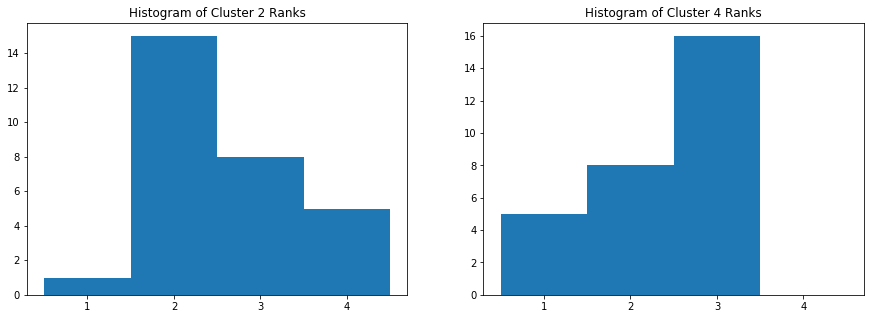

In [67]:
# plot histograms of the ranks achieved by clusters 2 and 4
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.hist(df_CB_gb_rank.loc[2, :], bins=[1, 2, 3, 4, 5], align='left'), plt.xticks([1, 2, 3, 4])
plt.title('Histogram of Cluster 2 Ranks')

plt.subplot(1, 2, 2)
plt.hist(df_CB_gb_rank.loc[4, :], bins=[1, 2, 3, 4, 5], align='left'), plt.xticks([1, 2, 3, 4])
plt.title('Histogram of Cluster 4 Ranks')
plt.show()

From the histograms, it is apparent that cluster 2 achieves a rank of 2 in significantly more attributes than cluster 4.  The shapes of the histograms are almost mirror across the rank 2 and rank 3 bins.  The closeness of the mean rank of the two clusters is due to attributes in which cluster 2 ranks 4th where has cluster 4 ranks 4th in no categories.  Additionally, cluster 4 ranks 1st in 5 categories whereas cluster 2 ranks 1st in only 1 category.  The attributes where these clusters rank 1st and 4th could provide information related to the nature of the clusters.

In [68]:
for index, row in df_CB_gb_rank.iterrows():
    first_list = []
    fourth_list = []    
    if (index in [2, 4]):
        for col_name in row.index:
            if (row[col_name] == 1):
                first_list.append(col_name)
            if (row[col_name] == 4):
                fourth_list.append(col_name)
        print('Attributes where cluster ' + str(index) + ' is ranked first.')
        print(first_list)
        print('Attributes where cluster ' + str(index) + ' is ranked fourth.')
        print(fourth_list)

Attributes where cluster 2 is ranked first.
['Strength']
Attributes where cluster 2 is ranked fourth.
['Acceleration', 'SprintSpeed', 'Agility', 'Balance', 'Jumping']
Attributes where cluster 4 is ranked first.
['Acceleration', 'SprintSpeed', 'Agility', 'Balance', 'Jumping']
Attributes where cluster 4 is ranked fourth.
[]


Cluster 2 is characterized by center backs are the strongest of the center backs but are fourth in categories that align with athleticism--'Acceleration', 'SprintSpeed', 'Agility', 'Balance', and 'Jumping'.  Conversely, cluster 4 is composed of center backs who are more athletic than other center backs with their high ratings in 'Acceleration', 'SprintSpeed', 'Agility', 'Balance', and 'Jumping'.  These clusters represent two types of center back that fall into the middle tier of overall center backs.